In [1]:
# %% Imports

import json
import logging
import pickle
import traceback
import uuid
from dataclasses import asdict, dataclass
from itertools import product

import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm

from factorization.config import DEVICE, SAVE_DIR
from factorization.data.modular import DataloaderConfig, SMADataloader
from factorization.models.softmax_model import Model

logger = logging.getLogger(__name__)

In [2]:
@dataclass
class ExperimentConfig:
    # data
    vocab_size: int = 2
    seq_length: int = 12
    sparsity_index: int = 5
    nb_data: int = 2048

    # optimization
    batch_size: int = 32
    nb_epochs: int = 1_000
    lr: float = 3e-3
    mlp_lr_discount: float = None

    # model
    emb_dim: int = 2
    nb_emb: int = None
    ffn_dim: int = None
    ffn_bias: bool = True
    ffn_dropout: float = 0
    activation: float = "gelu"

    # randomness
    seed: int = None
    MAX_FFN_DIM: int = 2048

    # saving
    save_ext: str = None
    save_weights: bool = False
    interactive: bool = True
    id: str = None

    def __init__(self, **kwargs):
        self.__dict__.update((k, v) for k, v in kwargs.items() if k in self.__annotations__)
        self.__post_init__()

    def __post_init__(self):
        if self.batch_size is None:
            self.batch_size = self.nb_data
        if self.nb_emb is None:
            self.nb_emb = self.vocab_size
        if self.ffn_dim is None:
            self.ffn_dim = 4 * self.emb_dim
        if self.id is None:
            self.id = uuid.uuid4().hex


In [8]:
config = ExperimentConfig(
    seed=0,
    nb_emb=3,
)


RNG = np.random.default_rng(config.seed)
np.random.seed(seed=config.seed)
torch.manual_seed(seed=config.seed)

if config.save_ext is None:
    save_dir = SAVE_DIR / config.id
else:
    save_dir = SAVE_DIR / config.save_ext / config.id

save_dir.mkdir(exist_ok=True, parents=True)
with open(save_dir / "config.json", "w") as f:
    json.dump(asdict(config), f)

# Data

data_config = DataloaderConfig(
    vocab_size=config.vocab_size,
    seq_length=config.seq_length,
    sparsity_index=config.sparsity_index,
    nb_data=config.nb_data,
    batch_size=config.batch_size,
    mode="train",
)
train_loader = SMADataloader(data_config, rng=RNG, device=DEVICE)
data_config.mode = "test"
test_loader = SMADataloader(data_config, rng=RNG, device=DEVICE)

X_train = train_loader.dataset.data
Y_train = train_loader.dataset.targets
X_test = test_loader.dataset.data
Y_test = test_loader.dataset.targets

logger.info(f"Training set: {train_loader.dataset}")
logger.info(f"Testing set: {test_loader.dataset}")

# Model

config.vocab_size = config.nb_emb
model = Model(config)
model.pos_emb.weight.data[:5] = torch.tensor([0, 1])
model.pos_emb.weight.data[5:] = torch.tensor([0, -1])
model.to(device=DEVICE)
logger.info(f"Model with {sum(p.numel() for p in model.parameters())} parameters, running on {DEVICE}")

# Adapative updates

if config.mlp_lr_discount is not None:
    mlp_params = [f"mlp.{n}" for n, p in model.mlp.named_parameters()]
    parameters = [
        {"params": [p for n, p in model.named_parameters() if n not in mlp_params]},
        {"params": model.mlp.parameters(), "lr": config.lr / config.mlp_lr_discount},
    ]
else:
    parameters = model.parameters()
optimizer = torch.optim.Adam(parameters, lr=config.lr)

# Training Loop

losses = torch.zeros(config.nb_epochs)
test_losses = torch.zeros(config.nb_epochs)
accs = torch.zeros(config.nb_epochs)
test_accs = torch.zeros(config.nb_epochs)


for epoch in (bar := tqdm(range(config.nb_epochs))):

    optimizer.zero_grad()

    # forward
    score = model(X_train, verbose=False)
    loss = F.cross_entropy(score, Y_train)

    # backward
    loss.backward()
    optimizer.step()

    # record statistics
    with torch.no_grad():
        losses[epoch] = loss.item()
        accs[epoch] = (score.argmax(-1) == Y_train).float().mean()
        score_test = model(X_test)
        test_losses[epoch] = F.cross_entropy(score_test, Y_test)
        test_accs[epoch] = (score_test.argmax(-1) == Y_test).float().mean()

    bar.set_postfix(loss=losses[epoch].item(), acc=accs[epoch].item(), test_acc=test_accs[epoch].item())

  3%|▎         | 27/1000 [00:00<00:07, 133.73it/s, acc=0.507, loss=0.97, test_acc=0.528] 

100%|██████████| 1000/1000 [00:06<00:00, 164.53it/s, acc=0.506, loss=0.649, test_acc=0.5] 


In [11]:
model.pos_emb.weight

Parameter containing:
tensor([[-0.0257,  0.9895],
        [-0.0147,  0.9970],
        [-0.0315,  0.9847],
        [-0.0222,  0.9912],
        [-0.0291,  0.9859],
        [ 0.0196, -1.0012],
        [ 0.0219, -1.0007],
        [-0.0193, -1.0102],
        [-0.0237, -1.0106],
        [ 0.0418, -0.9950],
        [-0.0371, -1.0141],
        [-0.0054, -1.0067]], device='cuda:0', requires_grad=True)

In [23]:
model.softmax.query.weight, config.vocab_size

(Parameter containing:
 tensor([[0.3057, 0.0361]], requires_grad=True),
 3)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

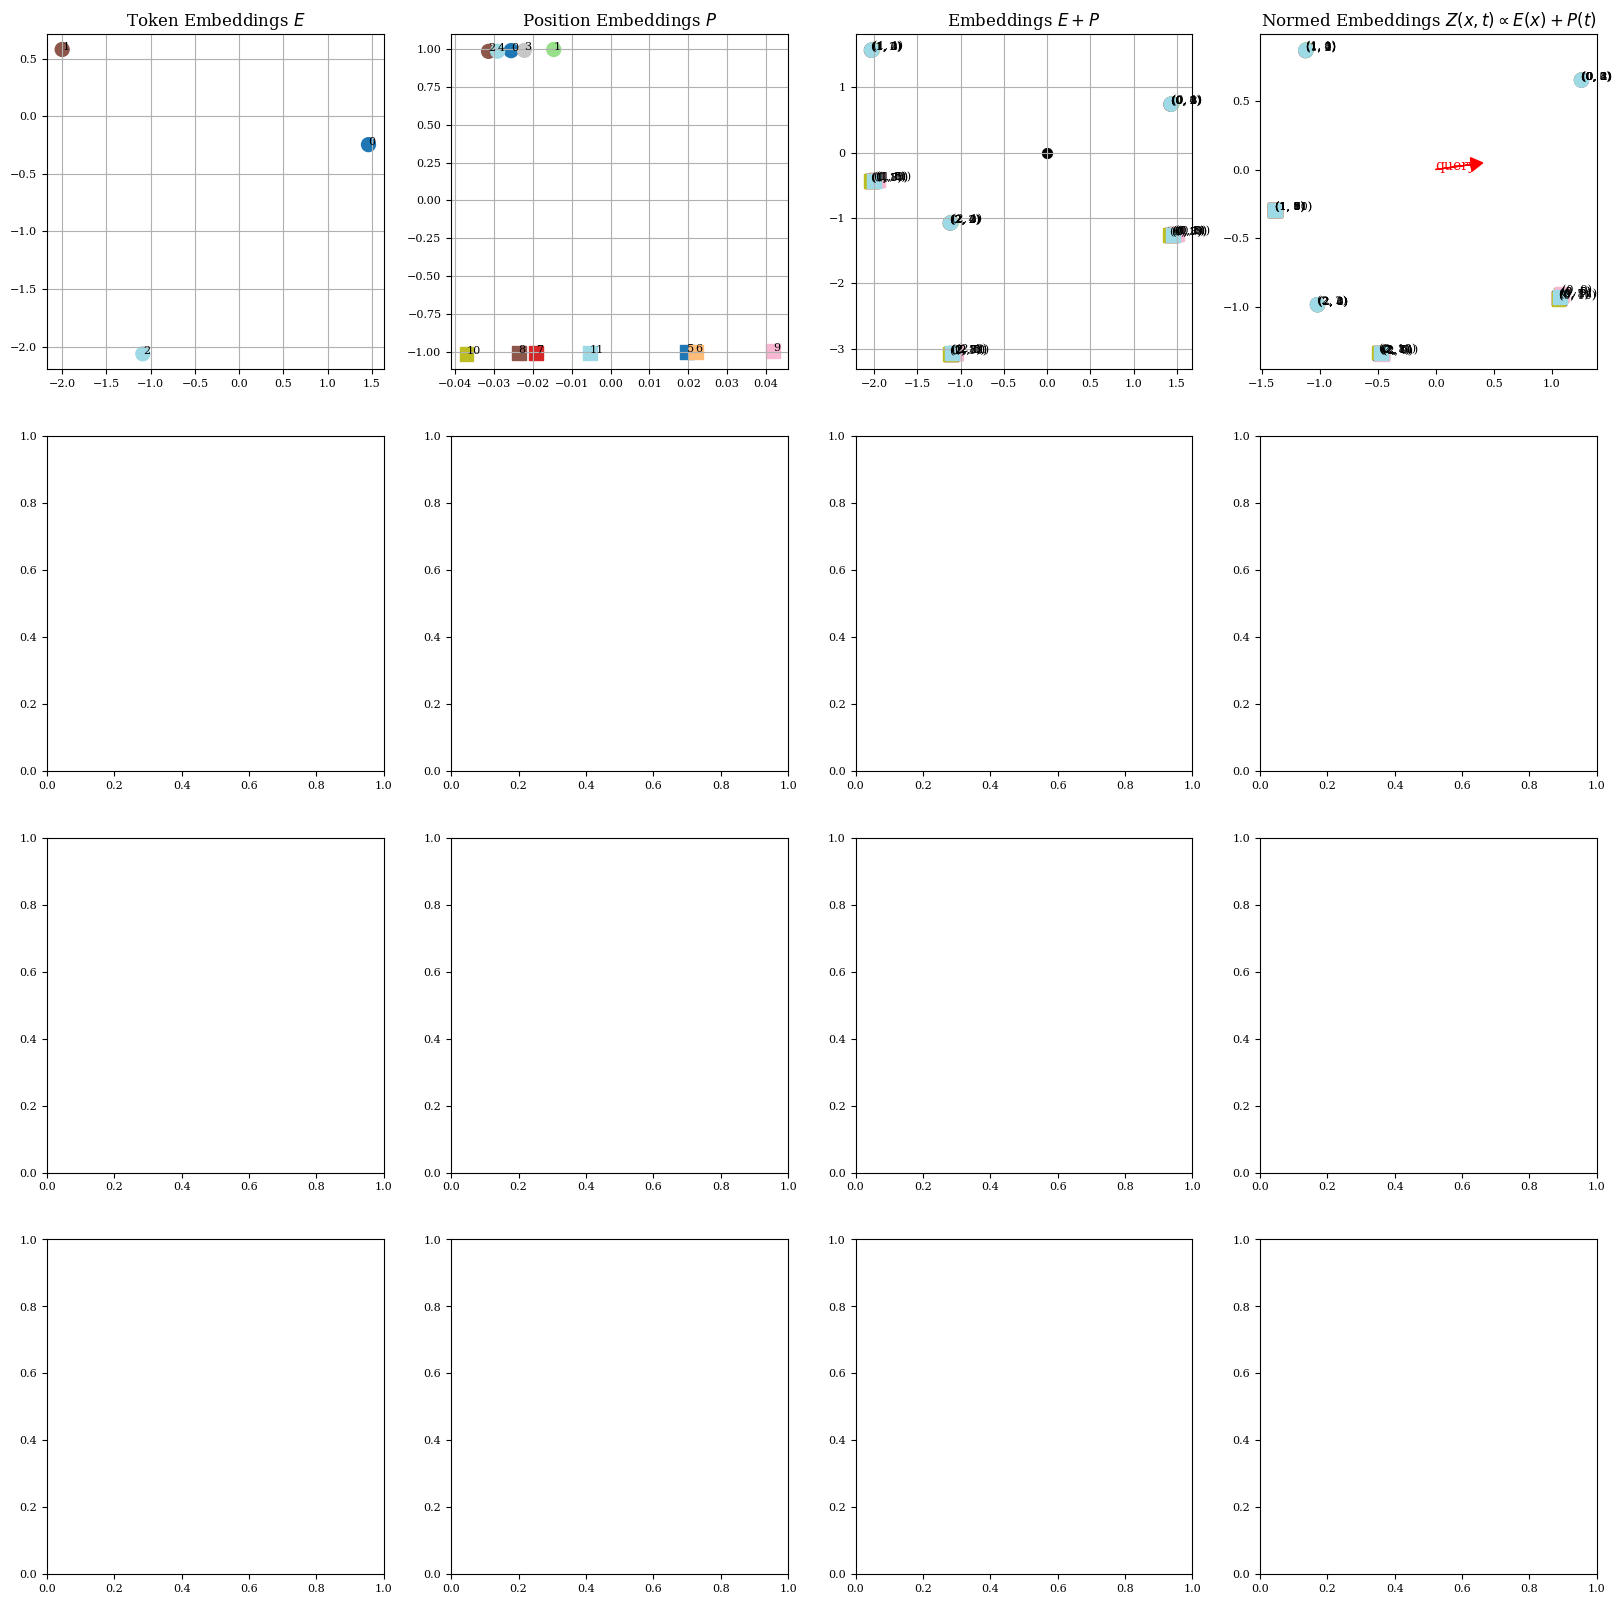

In [25]:
import sys
sys.path.append('..')

from visualization import *

norm = RMSNorm()

# variables

kwargs = {
    "DEVICE": DEVICE,
    "vocab_size": config.vocab_size,
    "sparsity_index": config.sparsity_index,
    "length": config.seq_length,
    "ffn_dim": config.ffn_dim,
    "losses": losses,
    "test_losses": test_losses,
    "accs": accs,
    "test_accs": test_accs,
    "text_fontsize": 8,
    "title_fontsize": 12,
    "pos_marker": "o",
    "neg_marker": "s",
    "third_marker": "^",
}

# plot configurations

plot_functions = {
    "show_token_emb": show_token_emb,
    "show_pos_emb": show_pos_emb,
    "show_emb": show_emb,
    "show_norm_emb": show_norm_emb,
    "show_attn": show_attn,
    "show_value": show_value,
    "show_seq_emb": show_seq_emb,
    "show_level_line": show_level_line,
    "show_norm_input": show_norm_input,
    "show_mlp_receptors": show_mlp_receptors,
    "show_mlp_emitters": show_mlp_emitters,
    "show_mlp_output": show_mlp_output,
    "show_output_level_lines": show_output_level_lines,
    "show_output": show_output,
    "show_loss": show_loss,
    "show_acc": show_acc,
}

plot_config = {
    "grid_size": [4, 4],
    "plots": [
        {"type": "show_token_emb", "position": [0, 0]},
        {"type": "show_pos_emb", "position": [0, 1]},
        {"type": "show_emb", "position": [0, 2]},
        {"type": "show_norm_emb", "position": [0, 3]},
        {"type": "show_attn", "position": [1, 0]},
        {"type": "show_value", "position": [1, 1]},
        {"type": "show_seq_emb", "position": [1, 2]},
        {"type": "show_level_line", "position": [1, 3]},
        {"type": "show_norm_input", "position": [2, 0]},
        {"type": "show_mlp_receptors", "position": [2, 1]},
        {"type": "show_mlp_emitters", "position": [2, 2]},
        {"type": "show_mlp_output", "position": [2, 3]},
        {"type": "show_output_level_lines", "position": [3, 0]},
        {"type": "show_output", "position": [3, 1]},
        {"type": "show_loss", "position": [3, 2]},
        {"type": "show_acc", "position": [3, 3]},
    ],
}

grid_size = plot_config["grid_size"]
plot_requests = plot_config["plots"]

WIDTH = 5 * grid_size[1]
HEIGHT = 5 * grid_size[0]
fig, axes = plt.subplots(*grid_size, figsize=(WIDTH, HEIGHT))

# frame creation

variables = ComputationCache(
    {
        "weights": {k: v.cpu().detach() for k, v in model.state_dict().items()},
        "model": model.to('cpu'),
        "norm": norm,
    }
    | kwargs
)

for plot_request in plot_requests:
    plot_type = plot_request["type"]
    position = tuple(plot_request["position"])
    plot_func = plot_functions.get(plot_type)

    if plot_func:
        ax = axes[position]
        plot_func(ax, variables)
    else:
        logger.info(f"Plot type {plot_type} not recognized.")